<a href="https://colab.research.google.com/github/Edward-TL/amazon_scraper/blob/master/Amazon_Mx_Music_Rank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Import

In [3]:
#For the system
import os

#Manage of time
from datetime import datetime, timedelta
from pytz import timezone
import time
import re

#Manage of files
import pandas as pd
import csv

#Graph tools
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import matplotlib.patches as mpatches

#interactive visualization
import plotly.express as px
import plotly.graph_objs as go

#Gauss-Jordan
import math

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
%cd 'drive/My Drive/Colab Notebooks/4SS/4SS_db/testing/Masters/mx/parquet'
!ls

/content/drive/My Drive/Colab Notebooks/4SS/4SS_db/testing/Masters/mx/parquet
mx-master_db_amazon-devices.parquet  mx-master_db_kitchen.parquet
mx-master_db_automotive.parquet      mx-master_db_musical-instruments.parquet
mx-master_db_baby.parquet	     mx-master_db_music.parquet
mx-master_db_books.parquet	     mx-master_db_officeproduct.parquet
mx-master_db_digital-text.parquet    mx-master_db_pet-supplies.parquet
mx-master_db_dvd.parquet	     mx-master_db_shoes.parquet
mx-master_db_electronics.parquet     mx-master_db_software.parquet
mx-master_db_grocery.parquet	     mx-master_db_sports.parquet
mx-master_db_handmade.parquet	     mx-master_db_tools.parquet
mx-master_db_hpc.parquet	     mx-master_db_toys.parquet
mx-master_db_industrial.parquet      mx-master_db_videogames.parquet


# Tools

## Count if

In [6]:
def count_if(array, value):
    count = 0
    for element in array:
        if element == value:
            count += 1
    return count

## array count

In [7]:
def array_count(elements_to_count, original_array):
    count_array = [None] * len(elements_to_count)
    c = 0

    for value in range(len(elements_to_count)):
        count_array[c] = original_array.count(elements_to_count[value])
        c += 1
        
    return count_array

## rank set list

In [8]:
def rank_set_list(df, rank, info, set_list=True, array=True):
    ranking = df[df['Rank'] == rank]
    raw_info_in_rank = ranking[info].to_list()

    if set_list == True:
        set_info = list(set(raw_info_in_rank))
        none_cases = count_if(set_info, None)
        if none_cases > 0:
            set_info.remove(None)

        if array == True:
            return set_info, raw_info_in_rank

        else: return set_info
    
    else: return raw_info_in_rank

    

In [10]:
def rank_info(df, rank, column_info, info_name='Albums'):
    set_info, raw_info_in_rank = rank_set_list(df, rank, column_info)
    info_count = array_count(elements_to_count=set_info, original_array=raw_info_in_rank)
    info = {info_name: set_info,
            'Counts' : info_count}
    df_info = pd.DataFrame(info)
    df_info = df_info.sort_values(by=['Counts'])

    return df_info

In [36]:
def plot_rank_barh(x, y, rank):
    plt.figure(figsize=(8,8))
    plt.barh(y=y, width=x)

    for i, v in enumerate(x):
        plt.text(v+1, i, str(v), fontweight='bold')

    xlabel = f'Times shown at #{rank} position' 
    plt.xlabel(xlabel)

    header = f'Times an album hit the #{rank} position' 
    plt.title(label=header)

    plt.show()

In [30]:
def barh_and_scatters(pivot_column, df_info=df, top_rank=5, extracted_info_name='Albums', n_plots=1):

    top = top_rank + 1 
    info = pivot_column
    df = df_info

    for rank in range(1, top):
        
        #Extract Info
        
        extracted_df = rank_info(df, rank, info, extracted_info_name)
        albums = extracted_df[extracted_info_name].to_list()
        info_count = extracted_df['Counts'].to_list()

        #Plot
        plot_rank_barh(info_count, albums, rank)

        # scatter
        rank_df = df[df['Rank'] == rank]
        x = rank_df['Stars']
        y = rank_df['Reviews']
        
        groups = rank_df.groupby(info)        
        markers = ['o', 'x', 'v', 'p']
        fig, ax = plt.subplots()
        m = 0
        p = 0
        

        for name, group in groups:
            if (m % 10 == 0) and (m > 0):
                p += 1

            ax.plot(group.Stars , group.Reviews, marker=markers[p], linestyle='', label=name)
            m += 1

        plt.legend(loc='best', bbox_to_anchor=(1,1), ncol=2)

In [67]:
def barh_plus_scatter(pivot_column, df_info=df, top_rank=5, extracted_info_name='Albums', n_plots=1, w_fig=8, h_fig=8):
    top = top_rank + 1 
    info = pivot_column
    df = df_info

    for rank in range(1, top):
        
        #Extract Info
        
        extracted_df = rank_info(df, rank, info, extracted_info_name)
        albums = extracted_df[extracted_info_name].to_list()
        info_count = extracted_df['Counts'].to_list()

        #Plot
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(w_fig, h_fig))
        title = f'#{rank} Info' 
        fig.suptitle(title)
        # plt.figure(figsize=(w_fig,h_fig))

        ax1.barh(y=albums, width=info_count)

        for i, v in enumerate(info_count):
            ax1.text(v+1, i, str(v), fontweight='bold')

        xlabel = f'Times shown at #{rank} position' 
        ax1.set_xlabel(xlabel)

        bar_header = f'Times an album hit the #{rank} position' 
        ax1.set_title(label=bar_header)

        # scatter
        rank_df = df[df['Rank'] == rank]
        x = rank_df['Stars']
        y = rank_df['Reviews']
        
        groups = rank_df.groupby(info)        
        markers = ['o', 'x', 'v', 'p']
        
        m = 0
        p = 0
        for name, group in groups:
            if (m % 10 == 0) and (m > 0):
                p += 1

            ax2.plot(group.Stars , group.Reviews, marker=markers[p], linestyle='', label=name)
            m += 1

        ax2.legend(loc='best', bbox_to_anchor=(1,1), ncol=2)
        plt.show()

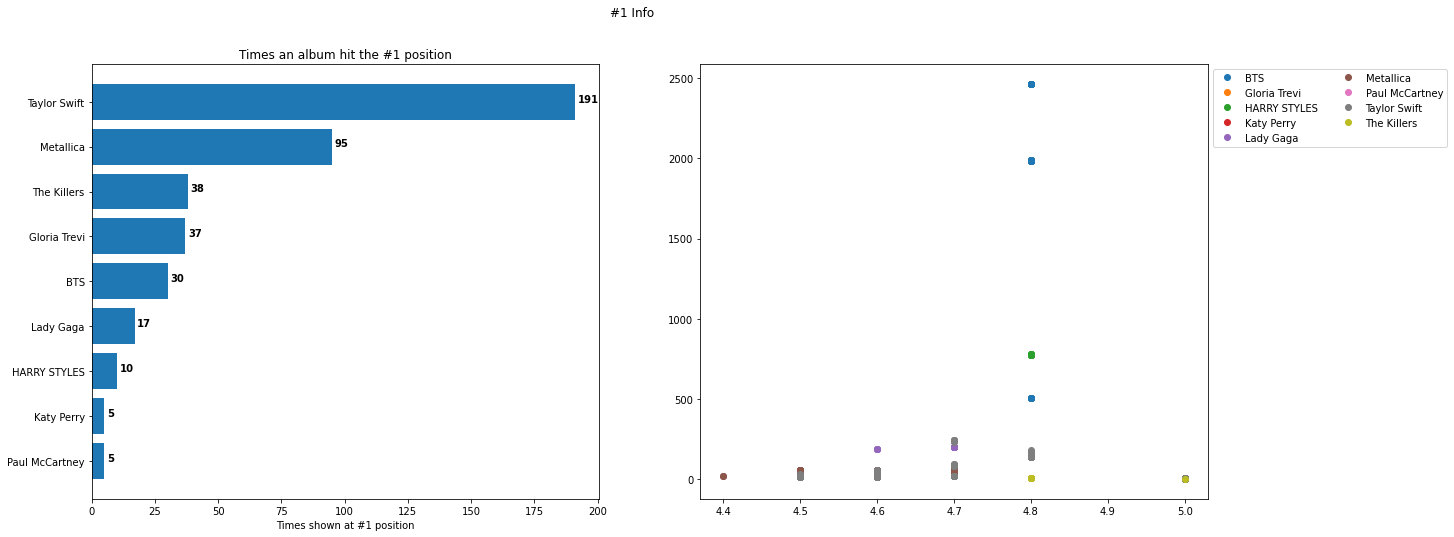

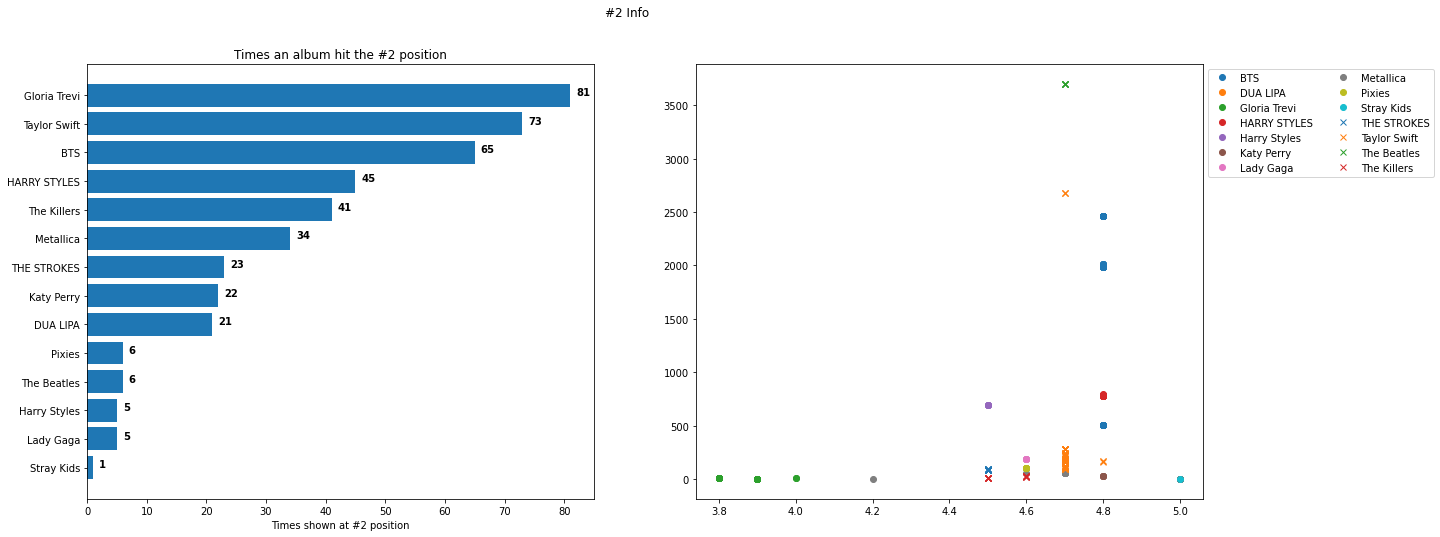

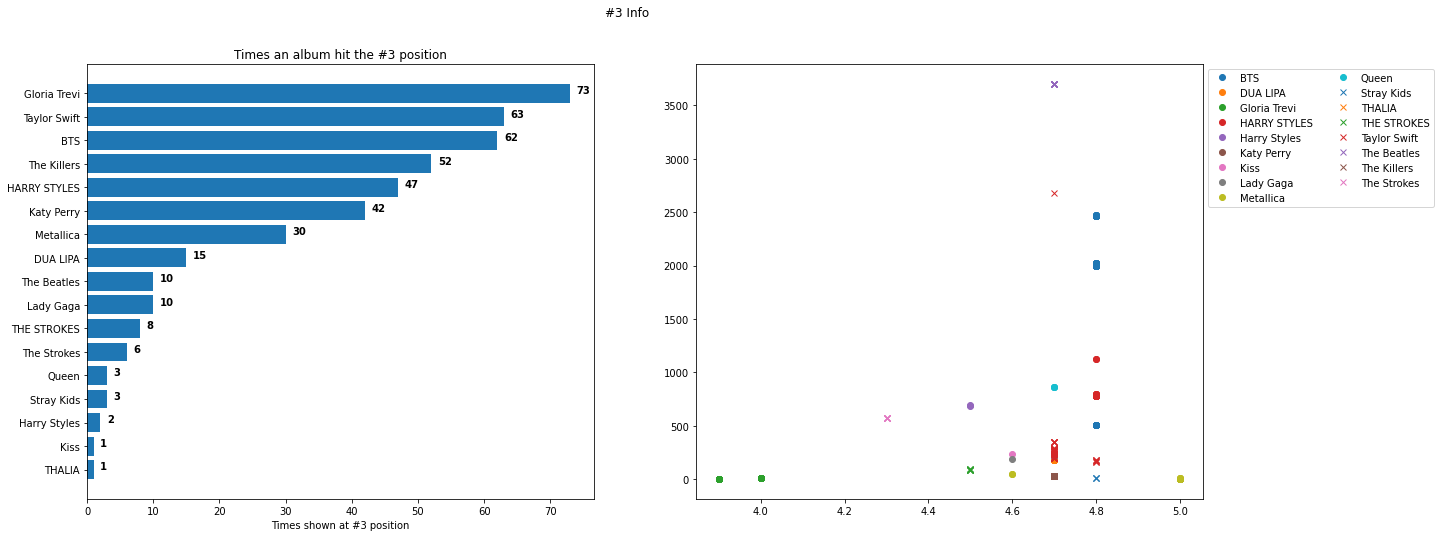

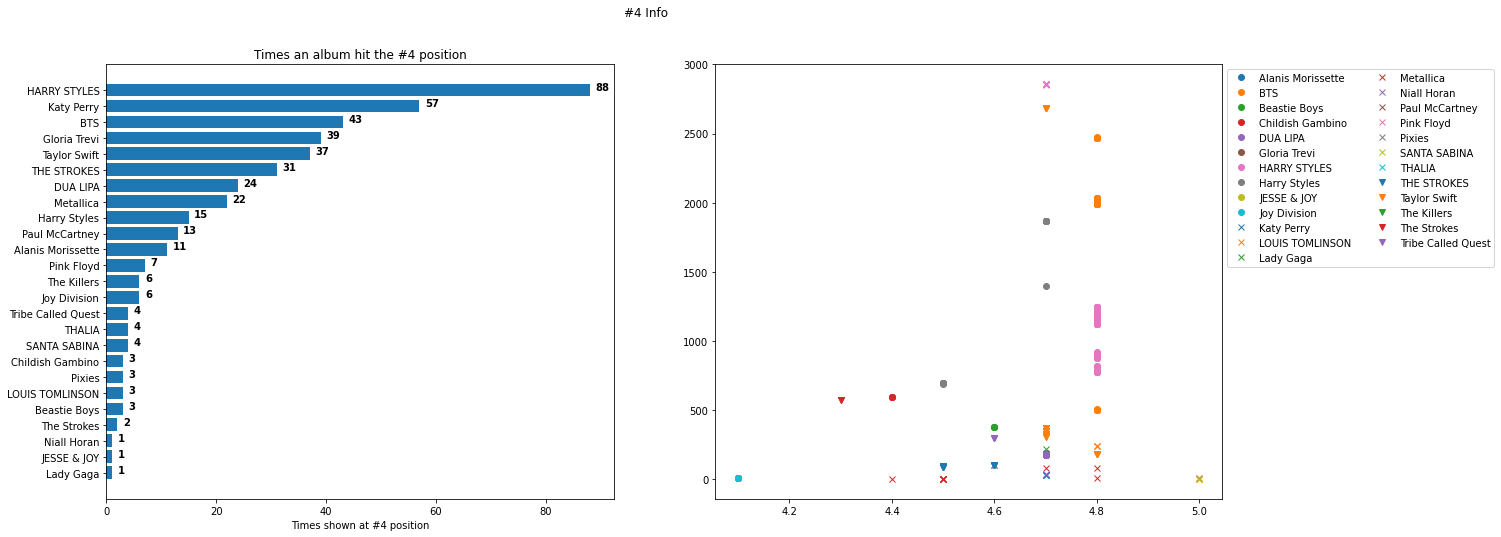

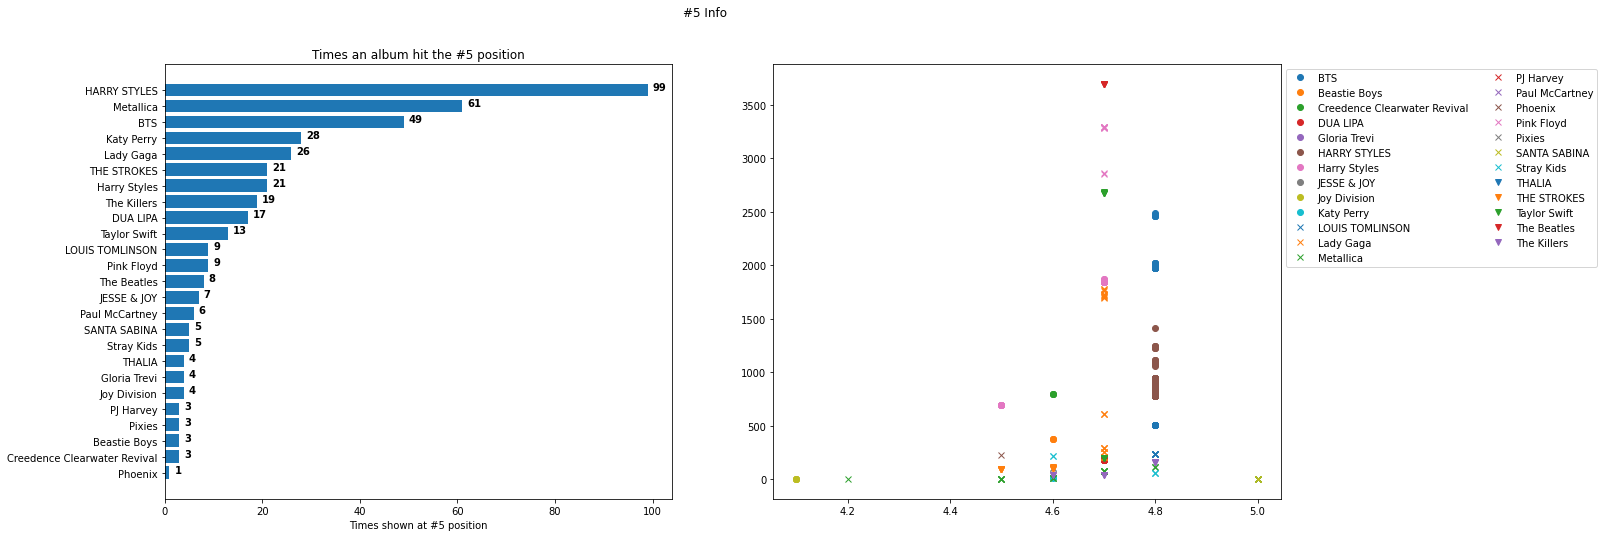

In [70]:
barh_plus_scatter(artist, top_rank=5, w_fig=20, h_fig=8)

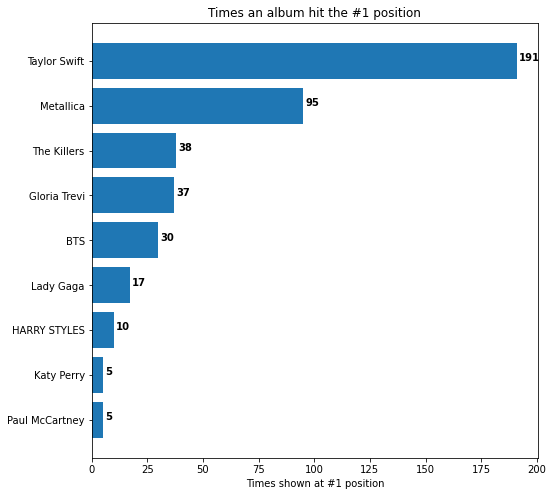

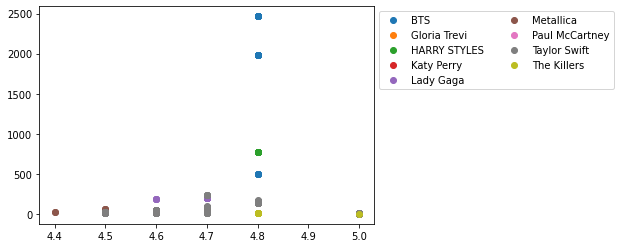

In [37]:
artist = 'Authors/Company'
barh_and_scatters(artist, top_rank=1)

In [5]:
df = pd.read_parquet('mx-master_db_music.parquet')
df.columns

Index(['time', 'Rank', 'Product Names', 'Product ID', 'Image ID', 'Stars',
       'Reviews', 'Authors/Company', 'Edition/Console', 'Price_std_or_min',
       'Max_prices'],
      dtype='object')

In [ ]:
album = 'Product Names'
barh_and_scatters(album)

# Plots

In [12]:
groups = rank_df.groupby('Rank')
groups

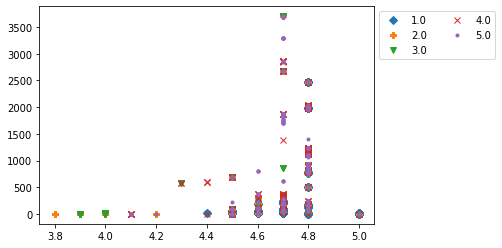

In [13]:
top_5 = df[(df['Rank'] >= 1) & (df['Rank']<=5)]
groups = top_5.groupby('Rank')
# Plot
fig, ax = plt.subplots()

p = 0
markers = ['D', 'P', 'v', 'x', '.']

for name, group in groups:
    ax.plot(group.Stars , group.Reviews, marker=markers[p], linestyle='', label=name)
    p += 1

plt.legend(loc='best', bbox_to_anchor=(1,1), ncol=2)

In [14]:
best_seller = df[df[album] == 'Folklore']
best_seller.columns

Index(['time', 'Rank', 'Product Names', 'Product ID', 'Image ID', 'Stars',
       'Reviews', 'Authors/Company', 'Edition/Console', 'Price_std_or_min',
       'Max_prices'],
      dtype='object')

In [15]:
x_values = best_seller['time'].dropna()
y_values = best_seller['Rank'].dropna()

date_format = mdates.DateFormatter('%d')
plt.xlabel('August Days')




# ax = plt.gca()

# # formatter = mdates.DateFormatter("%d-%m")
# # ax.xaxis.set_major_formatter(formatter)


plt.plot(x_values, y_values)
plt.


SyntaxError: ignored